# Exploratory Data Analysis

While using datasets such as MNIST, Fashion MNIST and QMNIST, Exploratory Data Analysis (EDA) entails information and data investigation on characteristics, distribution, and outliers. For these image datasets, there are several types of EDA you can perform:

In [1]:
import os
import torch
import pickle
import torchvision

import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import ndimage
from collections import Counter
from torchvision import transforms
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.metrics import confusion_matrix, classification_report

### Loading MNIST Dataset

In [2]:
# Define the transformations to apply to each image
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

# Load the MNIST training and testing datasets
mnist_train = torchvision.datasets.MNIST(
    root='./data',  # Directory where the data will be stored
    train=True,     # Load the training dataset
    transform=transform,  # Apply the transformations
    download=True   # Download the dataset if not already present
)

mnist_test = torchvision.datasets.MNIST(
    root='./data',
    train=False,    # Load the test dataset
    transform=transform,
    download=True
)

mnist_train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=32, shuffle=True)

### 1. Statistical Summary
#### Step 1: Class Distribution: 
- Count the number of images per class to check for class imbalance.

In [3]:
def describe_mnist_digit(dataset):
    # Extract data and labels
    data = [sample[0] for sample in dataset]  # Extract image tensors
    labels = [sample[1] for sample in dataset]  # Extract labels

    test = len(dataset) == 10000
    # Description
    print(f"Number of samples: {len(dataset)}")
    print(f"Data type: {type(data[0])}")
    print(f"Image dimensions: {data[0].shape}")
    if test:
        print(f"Label data type: {type(labels[0])}")
        print(f"Unique labels: {set(labels)}")

    class_counts = Counter(labels)

    # Prepare data for Seaborn
    classes = sorted(class_counts.keys())
    counts = [class_counts[cls] for cls in classes]

    # Create a Seaborn bar plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=classes, y=counts, hue=counts, palette=sns.color_palette("flare", n_colors=len(classes)))
    plt.xlabel("Classes", fontsize=14)
    plt.ylabel("Number of Samples", fontsize=14)
    plt.title(f"MNIST {'Test' if test else 'Train'} Dataset Class Distribution", fontsize=16)
    plt.xticks(classes)

    # Annotate counts on top of each bar
    for i, count in enumerate(counts):
        ax.text(i, count + max(counts) * 0.01,  # Slightly above the bar
                str(count), ha='center', va='bottom', fontsize=12)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Pie Chart for Class Distribution


In [4]:
def plot_class_distribution(data_loader):
    """
    Plot a pie chart to visualize the class distribution in the dataset.
    """
    # Count the occurrences of each class
    class_counts = np.zeros(10)  # For classes 0-9
    
    for images, labels in data_loader:
        for label in labels:
            class_counts[label.item()] += 1
    
    # Plotting the pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(class_counts, labels=2, autopct='%1.1f%%', startangle=140)
    plt.title('Class Distribution in MNIST Dataset')
    plt.show()

Train dataset

Number of samples: 60000
Data type: <class 'torch.Tensor'>
Image dimensions: torch.Size([1, 28, 28])


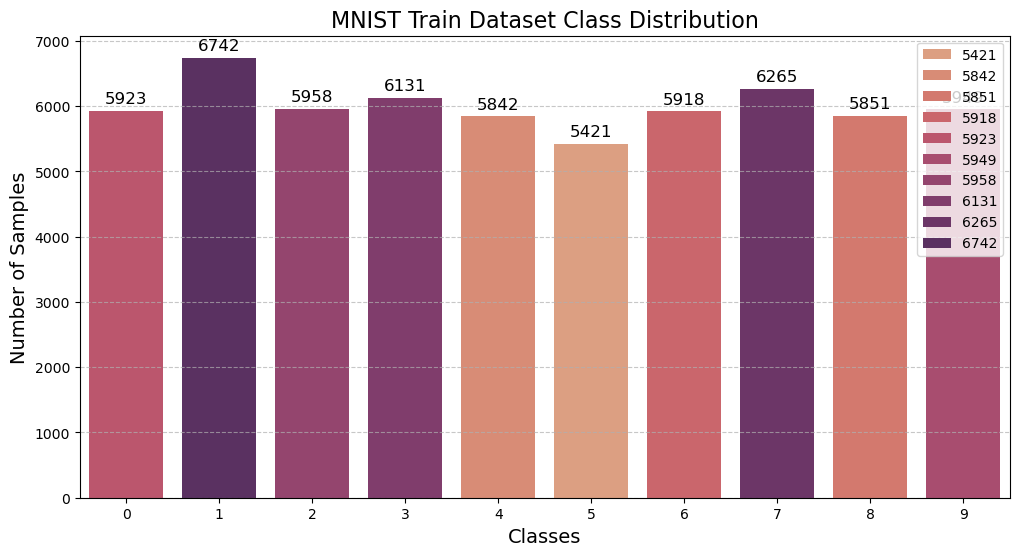

In [5]:
describe_mnist_digit(mnist_train)

TypeError: object of type 'int' has no len()

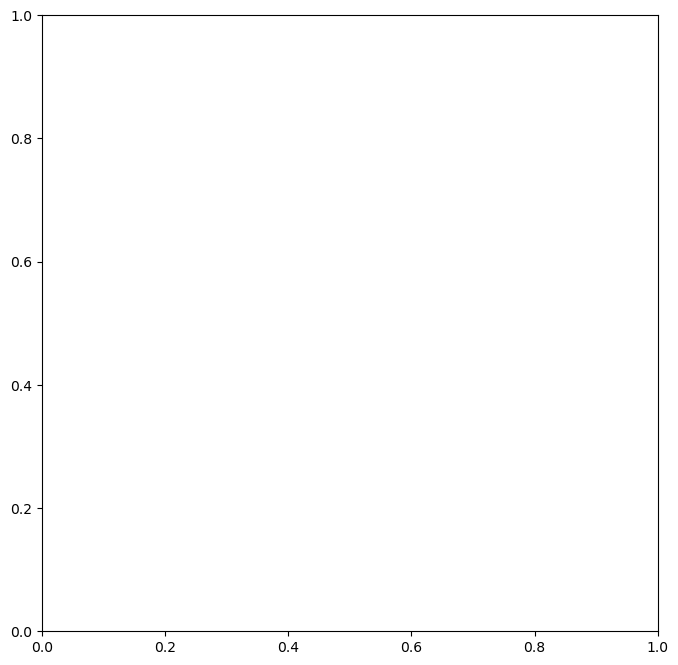

In [6]:
plot_class_distribution(mnist_train_loader)

Test dataset

Number of samples: 10000
Data type: <class 'torch.Tensor'>
Image dimensions: torch.Size([1, 28, 28])
Label data type: <class 'int'>
Unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


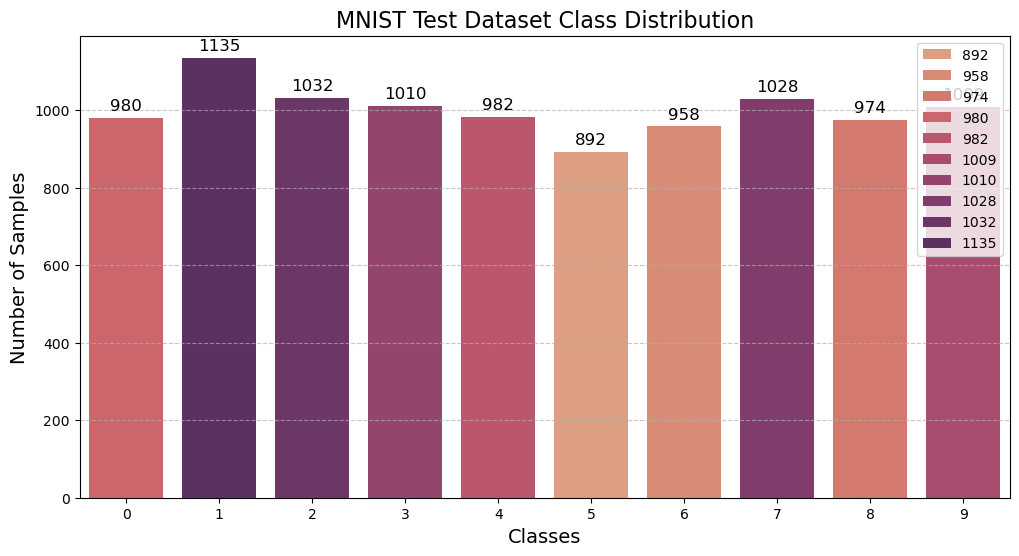

In [ ]:
describe_mnist_digit(mnist_test)

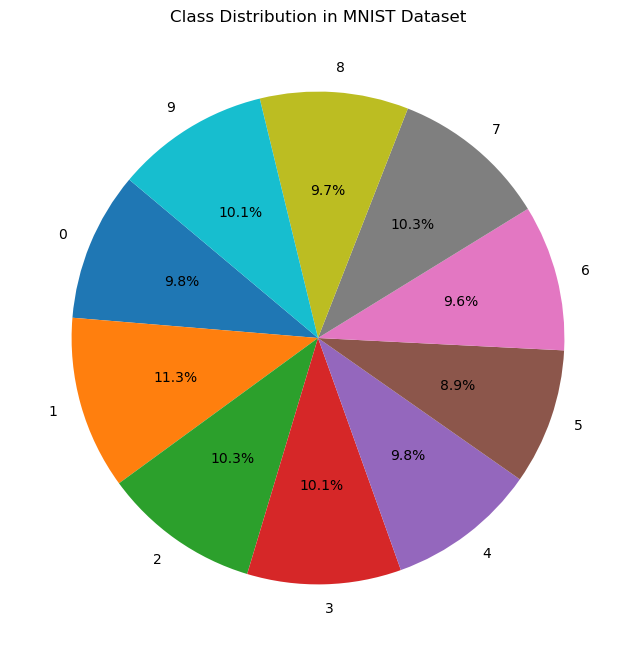

In [ ]:
plot_class_distribution(mnist_test_loader)

In [ ]:
# Check the shape of train_loader
for data, labels in mnist_train_loader:
    print(f"Train Data Shape: {data.shape}")
    print(f"Train Labels Shape: {labels.shape}")
    break  # Exit after inspecting the first batch

Train Data Shape: torch.Size([32, 1, 28, 28])
Train Labels Shape: torch.Size([32])


In [ ]:
# Check the shape of test_loader
for data, labels in mnist_test_loader:
    print(f"Test Data Shape: {data.shape}")
    print(f"Test Labels Shape: {labels.shape}")
    break  # Exit after inspecting the first batch

Test Data Shape: torch.Size([32, 1, 28, 28])
Test Labels Shape: torch.Size([32])


#### Step 2: Pixel Value Distribution



In [ ]:
import torch

def pixel_value_distribution(data_loader):
    """
    Analyze the distribution of pixel intensity values across the dataset.
    """
    all_pixel_values = []
    
    # Iterate through the DataLoader
    for images, _ in data_loader:
        # Flatten the image tensor and collect pixel values
        all_pixel_values.extend(images.view(-1).tolist())
    
    # Convert pixel values to a tensor
    all_pixel_values = torch.tensor(all_pixel_values)
    
    # Print the statistics for pixel values
    print("\nPixel Value Statistics:")
    print(f"Min Pixel Value: {all_pixel_values.min().item()}")
    print(f"Max Pixel Value: {all_pixel_values.max().item()}")
    
    return all_pixel_values


In [ ]:
pixel_value_distribution(mnist_train)


Pixel Value Statistics:
Min Pixel Value: -1.0
Max Pixel Value: 1.0


tensor([-1., -1., -1.,  ..., -1., -1., -1.])

In [ ]:
pixel_value_distribution(mnist_test)


Pixel Value Statistics:
Min Pixel Value: -1.0
Max Pixel Value: 1.0


tensor([-1., -1., -1.,  ..., -1., -1., -1.])

#### Step 3: Label Statistics
- Here, we ensure that all expected labels are present and check for any duplicates.

In [ ]:
def label_statistics(data_loader):
    """
    Ensure all expected labels are present and check for duplicates.
    """
    all_labels = []
    
    # Collect all labels in the dataset
    for _, labels in data_loader:
        all_labels.extend(labels.tolist())
    
    unique_labels = set(all_labels)
    
    # Check if all labels are present and if there are duplicates
    print("\nLabel Statistics:")
    print(f"Unique Labels Present: {sorted(unique_labels)}")
    print(f"Duplicate Labels: {'Yes' if len(all_labels) != len(set(all_labels)) else 'No'}")
    
    return unique_labels


In [ ]:
label_statistics(mnist_train_loader)


Label Statistics:
Unique Labels Present: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Duplicate Labels: Yes


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [ ]:
label_statistics(mnist_test_loader)


Label Statistics:
Unique Labels Present: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Duplicate Labels: Yes


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

### 2. Visualization
#### Sample Images: 
- Visualize a few random images from each class to understand what the data represents.



#### Class-wise Examples: 
- Compare images across classes to identify variations.

In [ ]:
import matplotlib.pyplot as plt
import random

def visualize_random_samples(data_loader, num_samples=5):
    """
    Visualize random sample images from the dataset, displaying a few examples for each class.
    """
    class_samples = {i: [] for i in range(10)}  # Create a dictionary to store samples for each class
    
    # Iterate over the data loader
    for images, labels in data_loader:
        for i in range(len(images)):
            class_samples[labels[i].item()].append(images[i])
        
        # Stop once we have enough samples for each class
        if all(len(class_samples[i]) >= num_samples for i in range(10)):
            break
    
    # Plot random samples from each class
    fig, axes = plt.subplots(10, num_samples, figsize=(12, 12))
    for i in range(10):
        for j in range(num_samples):
            ax = axes[i, j]
            ax.imshow(class_samples[i][j].squeeze(), cmap='gray')
            ax.axis('off')
            if j == 0:
                ax.set_ylabel(f'Class {i}', rotation=0, labelpad=10)
    
    plt.tight_layout()
    plt.show()

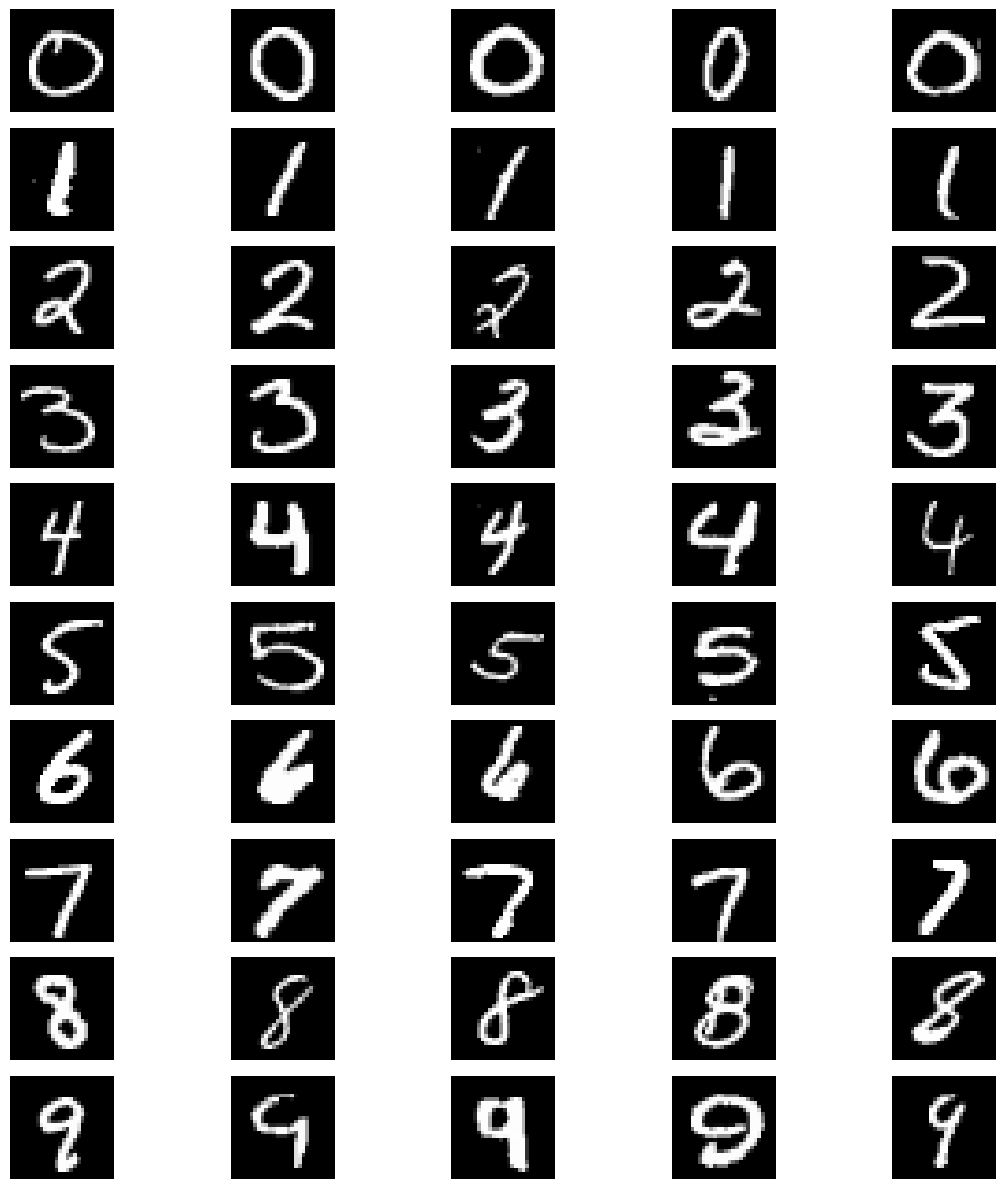

In [ ]:
visualize_random_samples(mnist_train_loader)

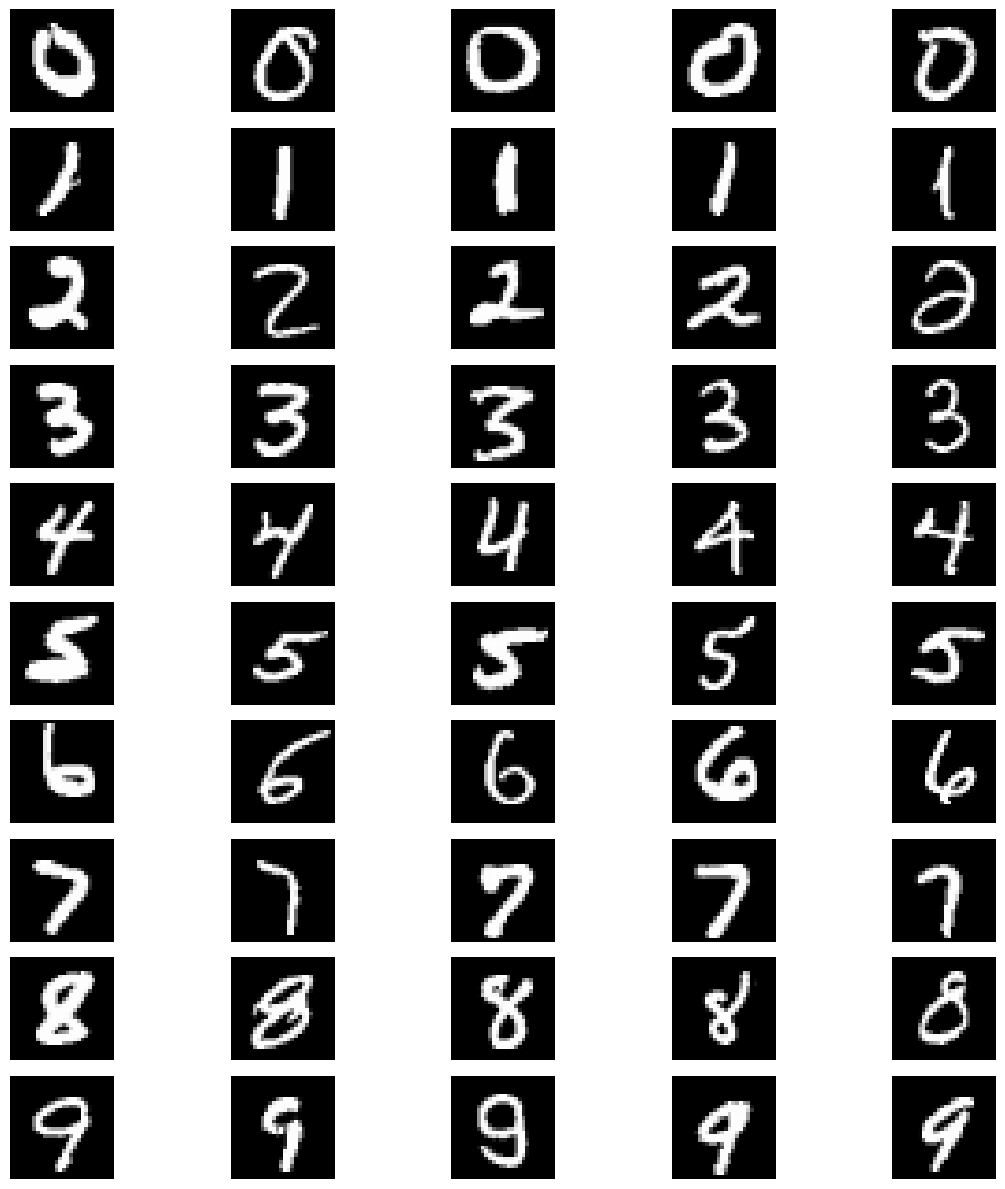

In [88]:
visualize_random_samples(mnist_test_loader)

#### Pixel Intensity Heatmaps: 
- Visualize the average image for each class to understand patterns.


In [93]:
import numpy as np

def pixel_intensity_heatmaps(data_loader):
    """
    Visualize the average image for each class using heatmaps.
    """
    class_images = {i: [] for i in range(10)}
    
    # Collect images for each class
    for images, labels in data_loader:
        for i in range(len(images)):
            class_images[labels[i].item()].append(images[i].numpy())
    
    # Calculate and plot average image for each class
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    for i in range(10):
        avg_image = np.mean(class_images[i], axis=0).squeeze()
        axes[i].imshow(avg_image, cmap='hot')
        axes[i].axis('off')
        axes[i].set_title(f'Class {i}')
    
    plt.tight_layout()
    plt.show()



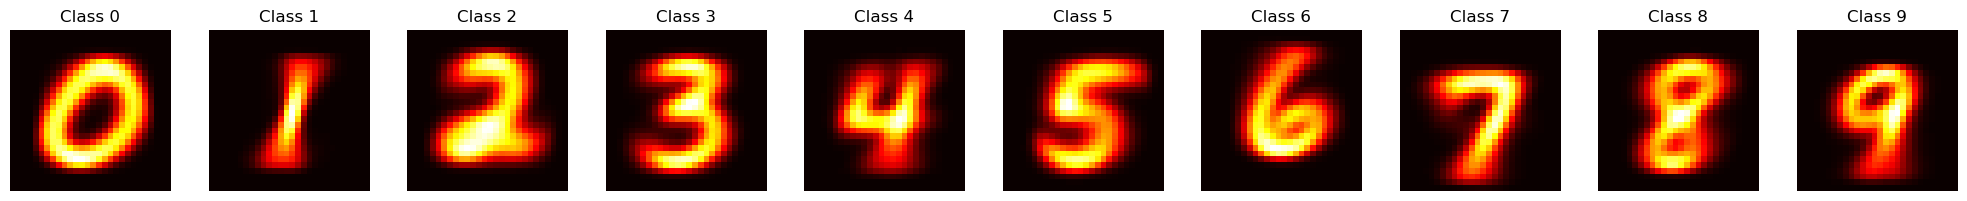

In [94]:
pixel_intensity_heatmaps(mnist_train_loader)

#### Dimensionality Reduction:
- Apply techniques like PCA (Principal Component Analysis) or t-SNE to visualize the dataset in 2D space.

In [96]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_visualization(data_loader, num_components=2):
    """
    Perform PCA on the MNIST dataset and plot the first 2 principal components.
    """
    # Prepare data: Flatten the images and collect labels
    images = []
    labels = []
    
    for batch_idx, (image_batch, label_batch) in enumerate(data_loader):
        images.append(image_batch.view(image_batch.size(0), -1))  # Flatten the image
        labels.append(label_batch)
        
        # Stop once we have all data
        if batch_idx == 100:  # Limit to 100 batches for speed (you can increase this for full data)
            break
    
    images = torch.cat(images, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    
    # Standardize the data (important for PCA)
    scaler = StandardScaler()
    images_scaled = scaler.fit_transform(images)
    
    # Apply PCA
    pca = PCA(n_components=num_components)
    pca_result = pca.fit_transform(images_scaled)
    
    # Plot PCA results
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='tab10', s=10)
    plt.title("PCA - MNIST Dataset")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.colorbar()
    plt.show()



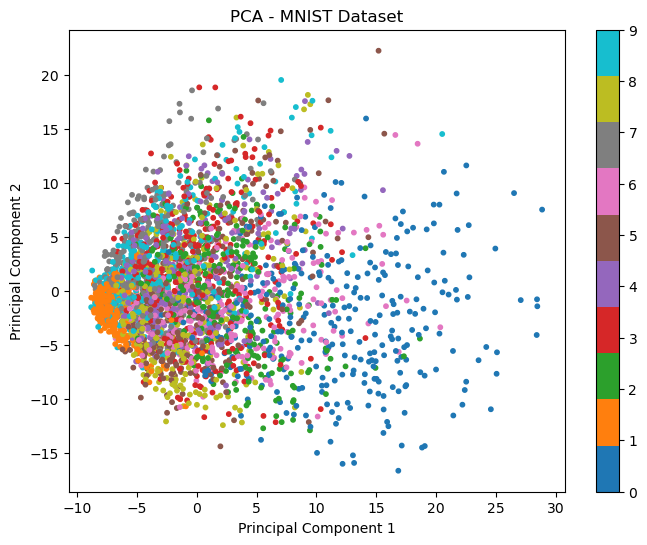

In [97]:
pca_visualization(mnist_train_loader)


### 3. Image-specific Analysis
#### Shape and Size Consistency: 
Verify if all images have consistent dimensions (e.g., 28x28 for MNIST).


In [3]:
def check_image_shape(data_loader, expected_shape=(28, 28)):
    """
    Verify that all images have the expected shape (28, 28 for MNIST).
    """
    for images, labels in data_loader:
        for image in images:
            if image.shape[1:] != expected_shape:
                print(f"Unexpected image shape: {image.shape[1:]}. Expected: {expected_shape}")
                return False
    print("All images have the expected shape.")
    return True

check_image_shape(mnist_train_loader)


All images have the expected shape.


True

#### Edge Detection: 
Use filters like Sobel or Canny to analyze edge patterns in the images.


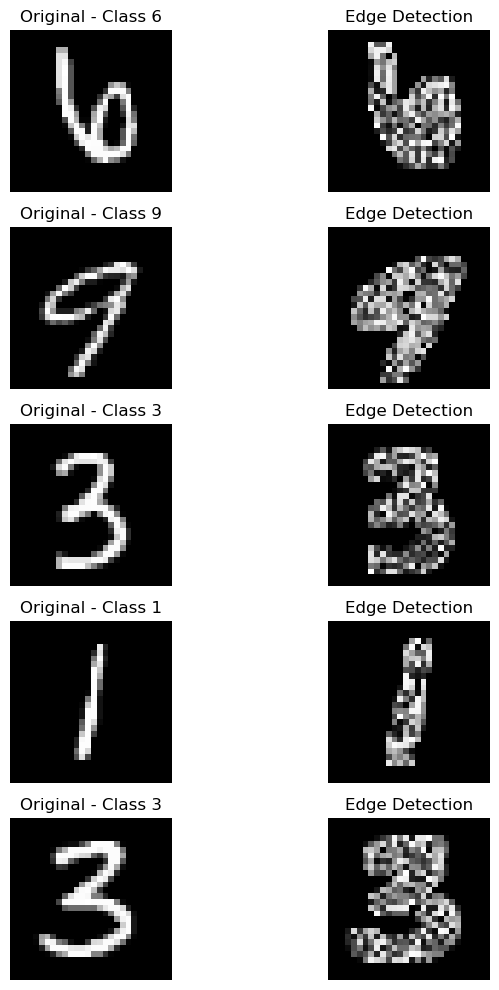

In [ ]:
def edge_detection(images):
    """
    Apply Sobel filter to detect edges in the image using SciPy.
    """
    edges = []
    for image in images:
        # Convert the image to numpy (from tensor), assuming it's normalized to [0, 1] in grayscale
        image_np = image.squeeze().cpu().numpy() * 255  # Convert to [0, 255]
        
        # Apply Sobel filter in both X and Y directions
        sobel_x = ndimage.sobel(image_np, axis=0)  # Sobel filter in the X direction
        sobel_y = ndimage.sobel(image_np, axis=1)  # Sobel filter in the Y direction
        sobel_edges = np.hypot(sobel_x, sobel_y)  # Combine the edges from both directions
        sobel_edges = np.uint8(sobel_edges)  # Convert back to uint8 for visualization
        edges.append(sobel_edges)
    return edges

# Example usage
def visualize_edges(data_loader, num_samples=5):
    """
    Visualize the original and edge-detected images.
    """
    images, labels = next(iter(data_loader))
    edges = edge_detection(images[:num_samples])
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 10))
    for i in range(num_samples):
        # Display original image
        axes[i, 0].imshow(images[i].squeeze(), cmap='gray')
        axes[i, 0].set_title(f'Original - Class {labels[i].item()}')
        axes[i, 0].axis('off')
        
        # Display edge-detected image
        axes[i, 1].imshow(edges[i], cmap='gray')
        axes[i, 1].set_title(f'Edge Detection')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_edges(mnist_train_loader)


##### Noise Analysis: 
Identify noisy or corrupted images.

Detected 8429 noisy images (variance > 0.5):
Image 1, Label 0, Variance 0.5618


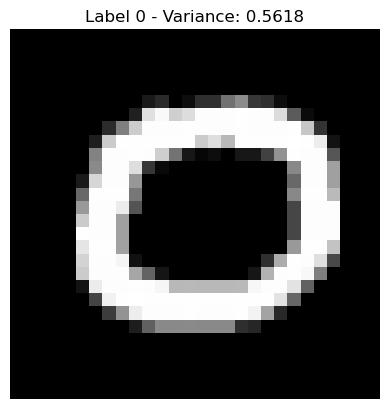

Image 2, Label 6, Variance 0.5257


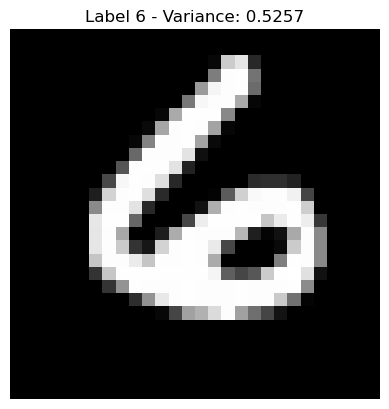

Image 3, Label 8, Variance 0.5596


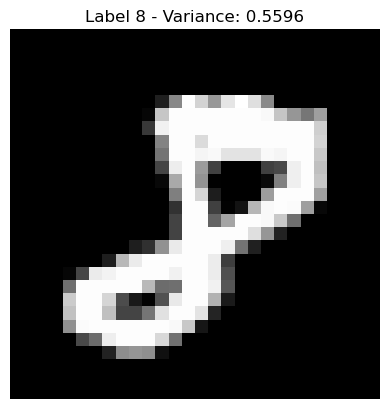

Image 4, Label 0, Variance 0.5587


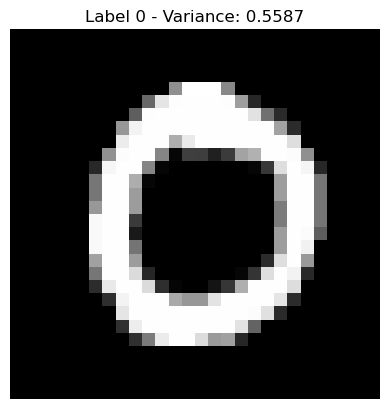

Image 5, Label 6, Variance 0.5534


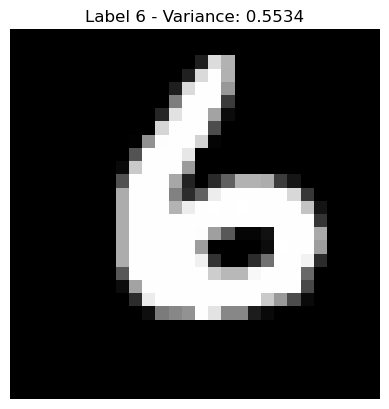

In [10]:
def noise_analysis(data_loader, threshold=0.5):
    """
    Detect noisy or corrupted images based on their pixel intensity variance.
    """
    noisy_images = []
    
    for images, labels in data_loader:
        for i, image in enumerate(images):
            # Calculate the variance (measure of noise)
            variance = torch.var(image).item()
            if variance > threshold:
                noisy_images.append((image, labels[i].item(), variance))
    
    # Report noisy images
    print(f"Detected {len(noisy_images)} noisy images (variance > {threshold}):")
    for i, (image, label, variance) in enumerate(noisy_images[:5]):  # Show only first 5 noisy images
        print(f"Image {i+1}, Label {label}, Variance {variance:.4f}")
        
        # Display noisy image
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f"Label {label} - Variance: {variance:.4f}")
        plt.axis('off')
        plt.show()

noise_analysis(mnist_train_loader)